In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from importlib import reload

import models
import plotting
import dataloaders as dl

In [2]:
def train(model, device, train_loader, optimizer, epoch, verbose=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)

        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0 and verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def train_adv(model, device, train_loader, optimizer, epoch, verbose=True):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        
        #noise = generate_adv_noise(model, 0.1, batch_size=train_loader.batch_size)
        noise = generate_adv_noise(model, 0.1, batch_size=10)
        output_adv = model(noise)
        
        loss = F.nll_loss(output, target) - output_adv.sum()/(10*train_loader.batch_size)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0 and verbose:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    av_conf = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss
            c, pred = output.max(1, keepdim=True) # get the index of the max log-probability
            correct += (pred.eq(target.view_as(pred))*(c.exp()>0.5)).sum().item()
            av_conf += c.exp().sum().item()
            
    test_loss /= len(test_loader.dataset)
    av_conf /= len(test_loader.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%), Ave. Confidence: {:.0f}%\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset), 100. * av_conf))
    return correct, av_conf

def test_adv(model, device, adv_test_loader):
    model.eval()
    av_conf = 0
    with torch.no_grad():
        for data, _ in adv_test_loader:
            data = data.to(device)
            output = model(data)

            c, pred = output.max(1, keepdim=True) # get the index of the max log-probability
            av_conf += c.exp().sum().item()
            
    av_conf /= len(adv_test_loader.dataset)

    print('\nAve. Confidence: {:.0f}%\n'.format(100.*av_conf))
    return av_conf

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [4]:
base_model = torch.load('base_model.pth').to(device)
robust_model = torch.load('gmm_model.pth').to(device)
robust_model_orig = torch.load('gmm_model.pth').to(device)

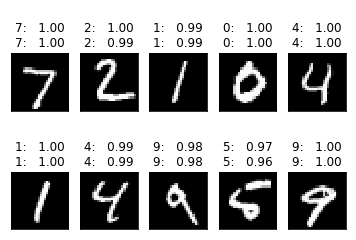

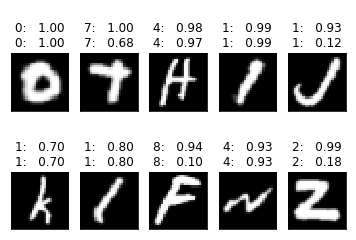

In [8]:


data = enumerate(dl.test_loader).__next__()[1][0]
y = robust_model(data.to(device))
y_base = base_model(data.to(device))

plotting.plot_samples([y_base, y], data)
    
data = enumerate(dl.EMNIST_test_loader).__next__()[1][0]
y = robust_model(data.to(device))
y_base = base_model(data.to(device))

plotting.plot_samples([y_base, y], data)

In [190]:
def generate_adv_noise(model, epsilon, batch_size=10, norm=2, num_of_it=10, alpha=0.01, seed_images=None):
    if seed_images is None:
        image = (.22*torch.rand((batch_size,1,28,28)))
        #image = (torch.rand((batch_size,1,28,28)))
    else:
        image = seed_images
    image = image.to(device).requires_grad_()

    perturbed_image = image
    for _ in range(num_of_it):
        y = model(perturbed_image)
        #loss = -y.max(dim=1)[0].sum()
        loss = -y.sum()
        loss.backward()

        with torch.no_grad():
            perturbed_image += alpha*image.grad

            delta = perturbed_image-image
            #delta /= delta.view((batch_size,784)).norm(p=norm, dim=1)[:,None,None,None]
            #delta *= epsilon
            perturbed_image = image + delta
            perturbed_image = torch.clamp(perturbed_image, 0, 1)

            perturbed_image = perturbed_image.detach()
    return perturbed_image

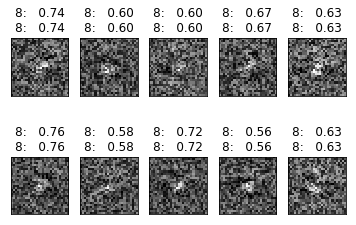

In [8]:
robust_model.eval()
perturbed_image = generate_adv_noise(base_model, .9)

y = robust_model(perturbed_image.to(device))
y_base = base_model(perturbed_image.to(device))

plot_samples(y_base, y, perturbed_image.detach().cpu())

In [37]:
import torch.optim as optim

lr = .00001
momentum = .9

#optimizer = optim.SGD([{"params":robust_model.gmm.parameters()}, {"params":robust_model.log_pz_lam}], lr=lr, momentum=momentum)

optimizer = optim.SGD(robust_model.parameters(), lr=lr, momentum=momentum)


for epoch in range(1):
    train_adv(robust_model, device, train_loader, optimizer, epoch)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.154872
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.401644
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.288798
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.354376
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.314350
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.236632


In [228]:
import torch.optim as optim

lr = .00001
momentum = .9

#optimizer = optim.SGD([{"params":robust_model.gmm.parameters()}, {"params":robust_model.log_pz_lam}], lr=lr, momentum=momentum)

optimizer = optim.SGD(base_model.parameters(), lr=lr, momentum=momentum)


for epoch in range(5):
    train_adv(base_model, device, train_loader, optimizer, epoch)

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.449592
Train Epoch: 0 [10000/60000 (17%)]	Loss: 0.344504
Train Epoch: 0 [20000/60000 (33%)]	Loss: 0.324980
Train Epoch: 0 [30000/60000 (50%)]	Loss: 0.330825
Train Epoch: 0 [40000/60000 (67%)]	Loss: 0.406912
Train Epoch: 0 [50000/60000 (83%)]	Loss: 0.322799
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.288756
Train Epoch: 1 [10000/60000 (17%)]	Loss: 0.303576
Train Epoch: 1 [20000/60000 (33%)]	Loss: 0.259763
Train Epoch: 1 [30000/60000 (50%)]	Loss: 0.274247
Train Epoch: 1 [40000/60000 (67%)]	Loss: 0.330723
Train Epoch: 1 [50000/60000 (83%)]	Loss: 0.305815
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.268931
Train Epoch: 2 [10000/60000 (17%)]	Loss: 0.253807
Train Epoch: 2 [20000/60000 (33%)]	Loss: 0.236782
Train Epoch: 2 [30000/60000 (50%)]	Loss: 0.204261
Train Epoch: 2 [40000/60000 (67%)]	Loss: 0.237642
Train Epoch: 2 [50000/60000 (83%)]	Loss: 0.248007
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.204603
Train Epoch: 3 [10000/60000 (17%)]	Loss: 0.212038
Train Epoch: 3 [2000

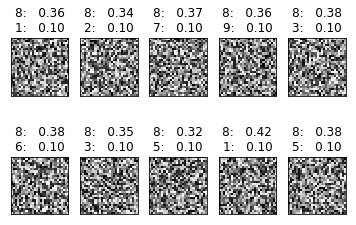

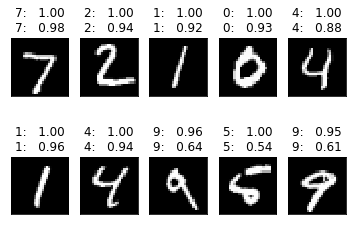

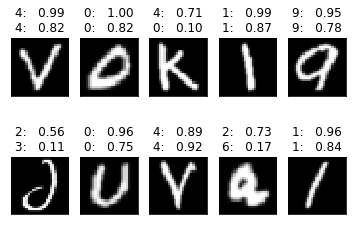

In [226]:
#robust_model.log_pz_lam.data = torch.tensor(-3864.).to(device)
robust_model.eval()

perturbed_image = generate_adv_noise(robust_model.base_model, 3.)

y = robust_model(perturbed_image.to(device))
y_base = base_model(perturbed_image.to(device))

plot_samples(y_base, y, perturbed_image.cpu())


data = enumerate(test_loader).__next__()[1][0]
y = robust_model(data.to(device))
y_base = base_model(data.to(device))

plot_samples(y_base, y, data)


data = enumerate(EMNIST_test_loader).__next__()[1][0]
y = robust_model(data.to(device))
y_base = base_model(data.to(device))

plot_samples(y_base, y, data)


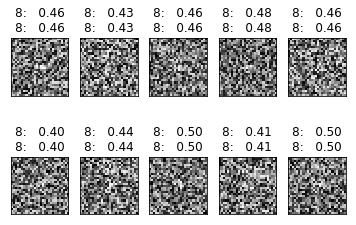

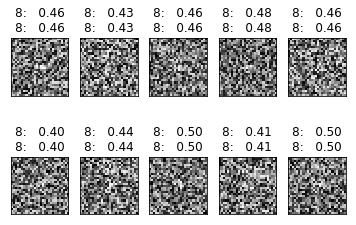

In [31]:
#perturbed_image = generate_adv_noise(robust_model_orig, 3.)
perturbed_image = generate_adv_noise(robust_model, .001, norm=float('inf'))

y = robust_model.base_model(perturbed_image.to(device))
y_base = base_model(perturbed_image.to(device))

plot_samples(y, y_base, perturbed_image.cpu())

#perturbed_image2 = generate_adv_noise(robust_model, .5, alpha=0.0001, num_of_it=100, seed_images=perturbed_image)

y = robust_model(perturbed_image.to(device))
y_base = base_model(perturbed_image.to(device))

plot_samples(y, y_base, perturbed_image.detach().cpu())

In [39]:
test(robust_model, device, test_loader)
test(robust_model_orig, device, test_loader)
test(base_model, device, test_loader)


Test set: Average loss: 0.2663, Accuracy: 8912/10000 (89%), Ave. Confidence: 82%


Test set: Average loss: 0.0734, Accuracy: 9740/10000 (97%), Ave. Confidence: 97%


Test set: Average loss: 0.0612, Accuracy: 9795/10000 (98%), Ave. Confidence: 97%



(9795, 0.9746231616020202)

In [40]:
test_adv(robust_model, device, EMNIST_test_loader)
test_adv(robust_model_orig, device, EMNIST_test_loader)
test_adv(base_model, device, EMNIST_test_loader)


Ave. Confidence: 39%


Ave. Confidence: 50%


Ave. Confidence: 82%



0.8164791568655234

In [23]:
robust_model.log_pz_lam

Parameter containing:
tensor(-764.3077, device='cuda:0', requires_grad=True)

In [39]:
import math
import numbers
import torch
from torch import nn
from torch.nn import functional as F

class GaussianSmoothing(nn.Module):
    """
    Apply gaussian smoothing on a
    1d, 2d or 3d tensor. Filtering is performed seperately for each channel
    in the input using a depthwise convolution.
    Arguments:
        channels (int, sequence): Number of channels of the input tensors. Output will
            have this number of channels as well.
        kernel_size (int, sequence): Size of the gaussian kernel.
        sigma (float, sequence): Standard deviation of the gaussian kernel.
        dim (int, optional): The number of dimensions of the data.
            Default value is 2 (spatial).
    """
    def __init__(self, channels, kernel_size, sigma, dim=2):
        super(GaussianSmoothing, self).__init__()
        if isinstance(kernel_size, numbers.Number):
            kernel_size = [kernel_size] * dim
        if isinstance(sigma, numbers.Number):
            sigma = [sigma] * dim

        # The gaussian kernel is the product of the
        # gaussian function of each dimension.
        kernel = 1
        meshgrids = torch.meshgrid(
            [
                torch.arange(size, dtype=torch.float32)
                for size in kernel_size
            ]
        )
        for size, std, mgrid in zip(kernel_size, sigma, meshgrids):
            mean = (size - 1) / 2
            kernel *= 1 / (std * math.sqrt(2 * math.pi)) * \
                      torch.exp(-((mgrid - mean) / std) ** 2 / 2)

        # Make sure sum of values in gaussian kernel equals 1.
        kernel = kernel / torch.sum(kernel)

        # Reshape to depthwise convolutional weight
        kernel = kernel.view(1, 1, *kernel.size())
        kernel = kernel.repeat(channels, *[1] * (kernel.dim() - 1))

        self.register_buffer('weight', kernel)
        self.groups = channels

        if dim == 1:
            self.conv = F.conv1d
        elif dim == 2:
            self.conv = F.conv2d
        elif dim == 3:
            self.conv = F.conv3d
        else:
            raise RuntimeError(
                'Only 1, 2 and 3 dimensions are supported. Received {}.'.format(dim)
            )

    def forward(self, input):
        """
        Apply gaussian filter to input.
        Arguments:
            input (torch.Tensor): Input to apply gaussian filter on.
        Returns:
            filtered (torch.Tensor): Filtered output.
        """
        return self.conv(input, weight=self.weight, groups=self.groups)

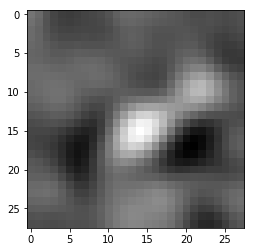

In [132]:
smoothing = GaussianSmoothing(1, 5, 10)
inp = perturbed_image2.cpu()
inp = F.pad(inp, (2, 2, 2, 2), mode='reflect')
output = smoothing(inp)
plt.imshow(output[1].squeeze(), cmap='gray', interpolation='none')

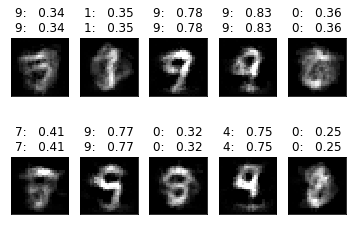

In [224]:
start = int(900*torch.rand(1))
d3 = d2[start:start+10]
perturbed_image2 = generate_adv_noise(robust_model, .3, norm=float('inf'), num_of_it=100, 
                                      alpha=0.01, seed_images=d3)

y = robust_model(perturbed_image2.to(device))
y_base = robust_model.base_model(perturbed_image2.to(device))

plot_samples(y, y_base, perturbed_image2.cpu())

In [103]:
perturbed_image2-=.8

In [212]:
d2.shape

torch.Size([1000, 1, 28, 28])

In [112]:
perturbed_image.min()

tensor(0.0995, device='cuda:0')

In [67]:
maxi = .1
for _ in range(100):
    maxi = max(robust_model.base_model(10*torch.rand((100,1,28,28)).to(device)).max().exp().item(), maxi)

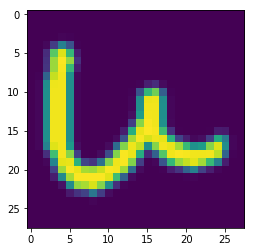

In [179]:
plt.imshow(data[0].cpu().squeeze())

In [103]:
d2 = []
for _, (data, _) in enumerate(test_loader):
    d2.append(data.mean(dim=0))
d2 = torch.stack(d2)

In [105]:
robust_model(d2[:10].to(device)).max().exp()

tensor(0.2491, device='cuda:0', grad_fn=<ExpBackward>)

In [92]:
d2 = torch.stack(d2)

In [126]:
d3 = d2[:10]

In [128]:
d3[d3>0].mean()

tensor(0.2473)

In [167]:
d4 = (d3>0).float()*torch.rand(10,1,28,28)

In [178]:
data = enumerate(EMNIST_test_loader).__next__()[1][0]